# 04 – Modeling & Evaluation
### Car Price Prediction Using Machine Learning
Group Assignment 02 - CCS3012 - Data Analytics  
Submission Date: 16th September 2025

---

### **Group 11**
-  **FC211034 - N.D. Samararathne Kodikara**
-  **FC211013 - N.W.V. Tharindu Pabasara**
-  **FC211025 - W.M.M.C.B. Wijesundara**



---


### **Supervisor**
**Ms. Dilmi Praveena**  
*Faculty of Computing*  
*University of Sri Jayewardenepura*

---


## 📌 Objectives

This notebook builds upon the cleaned dataset produced in **Notebook 01 — Data Exploration & Cleaning**.
The focus here is to prepare the dataset for modeling by performing outlier handling, feature engineering, and deterministic cleaning.

---

- Load processed train/test datasets and mappings from Notebook 02.

- Prepare numeric and categorical pipelines.

- Train and evaluate multiple regression models.

- Compare performance metrics (RMSE, MAE, R²) to select the best model.

- Save final model(s) for deployment or further analysis.


---

### 📂 Input  
- `clean_data.csv` saved in `Data/processed/`  
- `X_train.pkl, X_test.pkl`

- `y_train_log.pkl, y_test_log.pkl`

- `y_train_cap.pkl, y_test_cap.pkl`

- `categorical_mappings.pkl, model_mappings.pkl`


---

# imports

In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import pickle
import os

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Utility for saving
import joblib

# **Load Processed Data & Mappings**

## Load Data

In [2]:
# Load processed datasets
X_train = joblib.load('Data/processed/X_train.pkl')
X_test = joblib.load('Data/processed/X_test.pkl')

 # For scale-sensitive models
y_train_log = joblib.load('Data/processed/y_train_log.pkl')
y_test_log = joblib.load('Data/processed/y_test_log.pkl')

 # For tree-based models
y_train_cap = joblib.load('Data/processed/y_train_cap.pkl')
y_test_cap = joblib.load('Data/processed/y_test_cap.pkl')

In [3]:
# Load mappings
with open('Data/processed/categorical_mappings.pkl', 'rb') as f:
    categorical_mappings = pickle.load(f)

with open('Data/processed/model_mappings.pkl', 'rb') as f:
    model_mappings = pickle.load(f)

## Quick inspection

In [4]:
# Quick inspection
print("🔹 X_train shape:", X_train.shape)
print("🔹 X_test shape:", X_test.shape)

🔹 X_train shape: (12553, 29)
🔹 X_test shape: (3139, 29)


In [5]:
print("\n🔹 Train features:")
X_train.head(3)


🔹 Train features:


,fuel_type,cylinders,gear_box_type,drive_wheels,wheel,color,turbo,doors_count,doors_cat,cylinder_group,...,doors_domain,mileage_capped,engine_volume_capped,levy_capped,mileage_log,engine_volume_log,levy_log,manufacturer_grouped,model_median_price,is_top_luxury_model
2062,petrol,4,tiptronic,4x4,left-wheel,black,True,4,4-5,3-4,...,4_family,181155.0,2.0,707.00,12.107114,1.098612,6.562444,other,19130.0,0
3729,petrol,4,automatic,front,left-wheel,black,False,4,4-5,3-4,...,4_family,31000.0,1.5,595.00,10.341775,0.916291,6.390241,toyota,14113.0,0
1111,petrol,8,automatic,4x4,left-wheel,black,False,4,4-5,5-8,...,4_utility,264339.0,4.7,2056.44,12.484991,1.740466,7.629218,other,26500.0,0


In [6]:
print("🔹 Dataset info:\n")
X_train.info()

🔹 Dataset info:

<class 'pandas.core.frame.DataFrame'>
Index: 12553 entries, 2062 to 3447
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fuel_type             12553 non-null  object 
 1   cylinders             12553 non-null  int64  
 2   gear_box_type         12553 non-null  object 
 3   drive_wheels          12553 non-null  object 
 4   wheel                 12553 non-null  object 
 5   color                 12553 non-null  object 
 6   turbo                 12553 non-null  bool   
 7   doors_count           12553 non-null  int64  
 8   doors_cat             12553 non-null  object 
 9   cylinder_group        12553 non-null  object 
 10  cylinder_group_ord    12553 non-null  int64  
 11  airbags_group         12553 non-null  object 
 12  airbags_group_ord     12553 non-null  int64  
 13  car_age               12553 non-null  int64  
 14  has_leather           12553 non-null  int64  
 15  is_co

💡 **Observations:**  
- Overall, the dataset looks consistent and ready for pipeline preprocessing and model training.

# **Preprocessing Pipelines**

## Auto-detect numeric and categorical columns

In [7]:
# We treat booleans and numeric dtypes as numeric; object/category as categorical.
numeric_cols = X_train.select_dtypes(include=[np.number, 'bool']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Some columns we explicitly want to ensure are numeric.
# e.g., 'is_top_luxury_model' may be int; verify it's in numeric_cols.
for col in ['model_median_price', 'is_top_luxury_model']:
    if col in X_train.columns and col not in numeric_cols:
        numeric_cols.append(col)
        if col in categorical_cols: 
            categorical_cols.remove(col)

# Remove any accidental target-like names from features (safety)
for t in ['price', 'price_capped', 'price_log']:
    if t in numeric_cols: numeric_cols.remove(t)
    if t in categorical_cols: categorical_cols.remove(t)

print("🔹 Detected numeric columns:", numeric_cols)
print("\n🔹 Detected categorical columns (sample):", categorical_cols[:10], "... (total {})".format(len(categorical_cols)))

🔹 Detected numeric columns: ['cylinders', 'turbo', 'doors_count', 'cylinder_group_ord', 'airbags_group_ord', 'car_age', 'has_leather', 'is_common_color', 'engine_turbo', 'mileage_capped', 'engine_volume_capped', 'levy_capped', 'mileage_log', 'engine_volume_log', 'levy_log', 'model_median_price', 'is_top_luxury_model']

🔹 Detected categorical columns (sample): ['fuel_type', 'gear_box_type', 'drive_wheels', 'wheel', 'color', 'doors_cat', 'cylinder_group', 'airbags_group', 'domain', 'category_simple'] ... (total 12)


## Build preprocessors

In [8]:
#  Scaled preprocessor for scale-sensitive models (impute->scale, one-hot)
#  Tree preprocessor for tree-based models (impute->ordinal) — faster and compact

# numeric pipeline used by both
numeric_imputer = SimpleImputer(strategy='median')

preprocessor_scaled = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numeric_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                      ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
], remainder='drop')  # drop anything else

preprocessor_tree = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', numeric_imputer)]), numeric_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                      ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_cols)
], remainder='drop')

print("✅ Preprocessors created")

✅ Preprocessors created


# **Define model constructors**

## Define model constructors

In [9]:
def get_scale_sensitive_models():
    # These use y_log and require scaling
    return [
        ('LR', LinearRegression()),
        ('Ridge', Ridge()),
        ('Lasso', Lasso()),
        ('KNN', KNeighborsRegressor()),
        ('SVR', SVR())
    ]

def get_tree_models():
    # These use y_cap and do not require scaling
    return [
        ('RF', RandomForestRegressor(random_state=42, n_jobs=-1)),
        ('GBM', GradientBoostingRegressor(random_state=42))
    ]

print("✅ Model lists ready")

✅ Model lists ready


## CV evaluation function

In [10]:
def cross_validate_models(X, y, models, preprocessor, cv_folds=5, scoring='neg_root_mean_squared_error'):
    """
    Evaluate list of (name, model) using a pipeline that applies `preprocessor`.
    Returns a summary DataFrame and raw cv results dict.
    """
    results = {}
    summary_rows = []
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for name, model in models:
        pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
        # cross_val_score returns negative RMSE if scoring is 'neg_root_mean_squared_error'
        cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1)
        mean_rmse = -cv_scores.mean()
        std_rmse  = cv_scores.std()
        results[name] = cv_scores
        summary_rows.append({'model': name, 'mean_rmse': mean_rmse, 'std_rmse': std_rmse})
        print(f"{name}: Mean RMSE = {mean_rmse:.4f}, Std = {std_rmse:.4f}")

    summary_df = pd.DataFrame(summary_rows).sort_values('mean_rmse').reset_index(drop=True)
    return summary_df, results

## Run CV for baseline models

In [11]:
print("=== Scale-sensitive models (use y_log) ===")
scale_models = get_scale_sensitive_models()
summary_scale, results_scale = cross_validate_models(X_train, y_train_log, scale_models, preprocessor_scaled, cv_folds=5)

print("\n=== Tree-based models (use y_cap) ===")
tree_models = get_tree_models()
summary_tree, results_tree = cross_validate_models(X_train, y_train_cap, tree_models, preprocessor_tree, cv_folds=5)

print("\n--- Summary (scale-sensitive) ---")
display(summary_scale)
print("\n--- Summary (tree-based) ---")
display(summary_tree)

=== Scale-sensitive models (use y_log) ===
LR: Mean RMSE = 1.1627, Std = 0.0273
Ridge: Mean RMSE = 1.1627, Std = 0.0273
Lasso: Mean RMSE = 1.4176, Std = 0.0239
KNN: Mean RMSE = 1.1073, Std = 0.0218
SVR: Mean RMSE = 1.0727, Std = 0.0400

=== Tree-based models (use y_cap) ===
RF: Mean RMSE = 8019.8294, Std = 127.6733
GBM: Mean RMSE = 9152.1884, Std = 112.9927

--- Summary (scale-sensitive) ---


,model,mean_rmse,std_rmse
0,SVR,1.072684,0.040040
1,KNN,1.107262,0.021772
2,Ridge,1.162710,0.027331
3,LR,1.162743,0.027331
4,Lasso,1.417560,0.023920



--- Summary (tree-based) ---


,model,mean_rmse,std_rmse
0,RF,8019.829439,127.673328
1,GBM,9152.188386,112.992730


## Choose top models for final test eval

In [12]:
# Pick top scale-sensitive and top tree-based from CV results
best_scale_name = summary_scale.iloc[0]['model']
best_tree_name  = summary_tree.iloc[0]['model']
print(f"Top scale-sensitive: {best_scale_name}, top tree-based: {best_tree_name}")

# Map names to actual model instances
scale_dict = dict(scale_models)
tree_dict  = dict(tree_models)

best_scale_model = scale_dict[best_scale_name]
best_tree_model  = tree_dict[best_tree_name]

Top scale-sensitive: SVR, top tree-based: RF


## Fit best models on FULL train and evaluate on test

In [13]:
def fit_and_evaluate_on_test(X_train, y_train, X_test, y_test, preprocessor, model, target_is_log=False):
    """
    Fit pipeline on train (preprocessor+model), predict on test and compute metrics.
    If target_is_log==True: y_train and y_test are log-transformed; invert predictions before computing metrics.
    Returns pipeline, metrics dict, y_pred_original, y_test_original
    """
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred_raw = pipeline.predict(X_test)

    if target_is_log:
        # y_train/y_test were log1p; invert with expm1 for interpretation
        y_pred = np.expm1(y_pred_raw)
        y_true = np.expm1(y_test)
    else:
        y_pred = y_pred_raw
        y_true = y_test

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return pipeline, metrics, y_pred, y_true

## Evaluate scale-sensitive best on test (use y_log)

In [14]:
pipeline_scale_best, metrics_scale, ypred_scale, ytrue_scale = fit_and_evaluate_on_test(
    X_train, y_train_log, X_test, y_test_log, preprocessor_scaled, best_scale_model, target_is_log=True
)

print("\nBest scale-sensitive model test metrics (in original price units):")
print(metrics_scale)


Best scale-sensitive model test metrics (in original price units):
{'RMSE': np.float64(9381.76666538761), 'MAE': 5396.646927966022, 'R2': 0.6744667543569305}


## Evaluate tree-based best on test (use y_cap)

In [15]:
pipeline_tree_best, metrics_tree, ypred_tree, ytrue_tree = fit_and_evaluate_on_test(
    X_train, y_train_cap, X_test, y_test_cap, preprocessor_tree, best_tree_model, target_is_log=False
)

print("\nBest tree-based model test metrics (capped price units):")
print(metrics_tree)


Best tree-based model test metrics (capped price units):
{'RMSE': np.float64(8817.13856694303), 'MAE': 5146.695778162719, 'R2': 0.7124711511494108}


## Simple plots: predicted vs actual for both best models

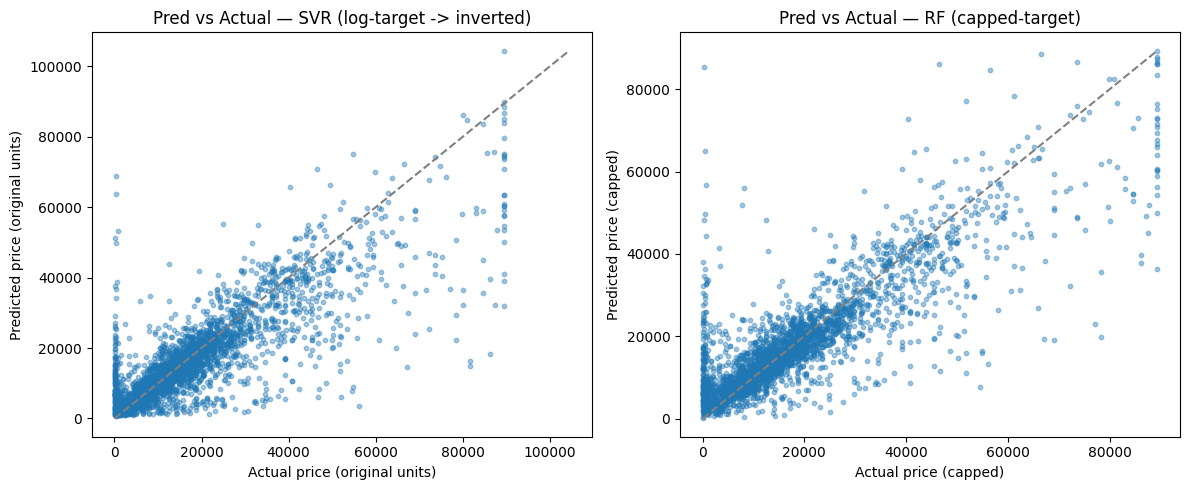

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(ytrue_scale, ypred_scale, alpha=0.4, s=10)
plt.xlabel("Actual price (original units)")
plt.ylabel("Predicted price (original units)")
plt.title(f"Pred vs Actual — {best_scale_name} (log-target -> inverted)")
lims = [min(ytrue_scale.min(), ypred_scale.min()), max(ytrue_scale.max(), ypred_scale.max())]
plt.plot(lims, lims, '--', color='gray')

plt.subplot(1,2,2)
plt.scatter(ytrue_tree, ypred_tree, alpha=0.4, s=10)
plt.xlabel("Actual price (capped)")
plt.ylabel("Predicted price (capped)")
plt.title(f"Pred vs Actual — {best_tree_name} (capped-target)")
lims2 = [min(ytrue_tree.min(), ypred_tree.min()), max(ytrue_tree.max(), ypred_tree.max())]
plt.plot(lims2, lims2, '--', color='gray')

plt.tight_layout()
plt.show()

## Save best pipelines

In [19]:
OUT_DIR = "models"
joblib.dump(pipeline_scale_best, os.path.join(OUT_DIR, f"best_pipeline_{best_scale_name}.pkl"))
joblib.dump(pipeline_tree_best, os.path.join(OUT_DIR, f"best_pipeline_{best_tree_name}.pkl"))
print(f"Saved best pipelines: best_pipeline_{best_scale_name}.pkl and best_pipeline_{best_tree_name}.pkl")


Saved best pipelines: best_pipeline_SVR.pkl and best_pipeline_RF.pkl


# **diagnostics + interpretability**

## Load back the saved pipelines

In [ ]:
# Load best models
scale_model = joblib.load(os.path.join(OUT_DIR, f"best_pipeline_{best_scale_name}.pkl"))
tree_model  = joblib.load(os.path.join(OUT_DIR, f"best_pipeline_{best_tree_name}.pkl"))
